In [1]:
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import time
from astropy.coordinates import GeocentricMeanEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import BarycentricTrueEcliptic
from astropy.coordinates import BarycentricMeanEcliptic
from astropy import coordinates 
import astropy

'''
    NAME:
         convert_to_primary_centric
         
    PURPOSE:
         This function takes a parameter Dataframe in RA/DEC, and converts it to Latitude 
         and Longitude, while also converting the dates to Primary-Centric Julian dates
         
    CALLING SEQUENCE:
         convert_to_primary_centric(paramsDF, objectName)
   
    INPUTS
          paramsDF - A dataframe of the observed positional data of the KBO in question
          objectName - The name of the object being observed (needed for the Horizons function)
   
    OUTPUTS:
          None. Just makes plots currently.
'''
def convert_to_primary_centric(paramsDF, objectNames, numobjects, sample_num):
     #Current column names are just descriptive, not representative of final product column names
    updatedDF = pd.DataFrame(columns = ['time'])
    
    #Convert the dates into a Julian date format
    date = paramsDF['time']
    dateList = []
    for i in date:
        jd = Time(i,format='jd')
        dateList.append(jd)
        
    #Get the Horizons data for the object at the times it was observed
    primary = Horizons(id=objectNames[0],location=None,epochs=dateList)
    
    updatedDF['time'] = paramsDF['time']-primary.vectors()['lighttime']
    
    
    #Pull all data from csv file
    #RA_Prim = np.array(paramsDF['RA-Primary'])
    #DEC_Prim = np.array(paramsDF['DEC-Primary'])
    RA_Prim = np.array(primary.ephemerides()['RA'][:])
    DEC_Prim = np.array(primary.ephemerides()['DEC'][:])
    
    for i in range(len(objectNames)-1):
    
        deltaRA_1 = np.array(paramsDF['Delta-RA_'+objectNames[i+1]]).astype(np.float)
        deltaDEC_1 = np.array(paramsDF['Delta-DEC_'+objectNames[i+1]]).astype(np.float)
    #deltaRA_Hiisi = np.array(paramsDF['Delta-RA_Hiisi'])
    #deltaDEC_Hiisi = np.array(paramsDF['Delta-DEC_Hiisi'])
    
        RA_1_err = np.array(paramsDF['Delta-RA_'+objectNames[i+1]+'-err']).astype(np.float)
        DEC_1_err = np.array(paramsDF['Delta-DEC_'+objectNames[i+1]+'-err']).astype(np.float)


        RA_1 = RA_Prim+deltaRA_1/3600/np.cos(DEC_Prim*u.degree)
        DEC_1 = DEC_Prim + deltaDEC_1/3600
    
        ra_err = np.zeros((len(RA_1), int(sample_num)))
        dec_err = np.zeros((len(DEC_1), int(sample_num)))
        
        for k in range(len(RA_1)):
            plt.figure(k)
            for j in range(sample_num):
                ra_err[k][j] = np.random.normal(RA_1[k]*3600, RA_1_err[k])/3600
                dec_err[k][j] = np.random.normal(DEC_1[k]*3600, DEC_1_err[k])/3600
            plt.scatter(ra_err[k],dec_err[k],s=10)
        
    #Essentially we define where the object is in our RA/DEC coordinate system. ICRS is the system our coordinates are in.
        dist = primary.vectors()['range']
        
        firstC = SkyCoord(ra=RA_1*u.degree, dec=DEC_1*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
        primC = SkyCoord(ra=RA_Prim*u.degree, dec=DEC_Prim*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
        firstEcl = firstC.transform_to(HeliocentricMeanEcliptic(equinox='J2000'))
        primEcl = primC.transform_to(HeliocentricMeanEcliptic(equinox='J2000'))
    
        Lat_Prim = primEcl.lat.degree
        Long_Prim = primEcl.lon.degree
    
        Lat_1 = firstEcl.lat.degree
        Long_1 = firstEcl.lon.degree
        
           
        Lat_err = np.zeros(len(ra_err))
        Long_err = np.zeros(len(dec_err))
        
        for j in range(len(ra_err)):
            plt.figure(len(ra_err)+j)
            Lat_err_arr = np.zeros(len(ra_err[0]))
            Long_err_arr = np.zeros(len(dec_err[0]))
            for k in range(len(ra_err[0])):
                coord_sky = SkyCoord(ra=(ra_err[j][k])*u.degree, dec=(dec_err[j][k])*u.degree, frame='icrs',distance = dist[j]*u.AU,unit=(u.deg,u.deg))
                transformed_coord = coord_sky.transform_to(HeliocentricMeanEcliptic(equinox='J2000'))
                Lat_err_arr[k] = transformed_coord.lat.degree
                Long_err_arr[k] = transformed_coord.lon.degree
            plt.scatter(Lat_err_arr,Long_err_arr)
            plt.gca().set_aspect('equal', adjustable='box')
            #Lat_err[j] = np.sum(Lat_err_arr)/len(Lat_err_arr)
            #Long_err[j] = np.sum(Long_err_arr)/len(Long_err_arr)
            Lat_err[j] = np.std(Lat_err_arr)
            Long_err[j] = np.std(Long_err_arr)
                
        
        DeltaLat_1 = (Lat_1-Lat_Prim)*3600
        DeltaLong_1 = (Long_1-Long_Prim)*np.cos(Lat_Prim*u.degree)*3600
        
        Lat_1_err_arc = (Lat_err)*3600
        Long_1_err_arc = (Long_err)*3600
    
    
        if i == 0:
            updatedDF['Lat_Prim'] = Lat_Prim
            updatedDF['Long_Prim'] = Long_Prim
    
        updatedDF['DeltaLat_'+objectNames[i+1]] = DeltaLat_1
        updatedDF['DeltaLong_'+objectNames[i+1]] = DeltaLong_1

        updatedDF['DeltaLat_'+objectNames[i+1]+'_err'] = Lat_1_err_arc
        updatedDF['DeltaLong_'+objectNames[i+1]+'_err'] = Long_1_err_arc

   
    print(updatedDF)
    
    updatedDF.to_csv('New'+objectNames[0]+'_LatLon.csv')
    

           time  Lat_Prim  Long_Prim  DeltaLat_Hiisi  DeltaLong_Hiisi  \
0  2.452252e+06 -8.365019   0.978783        0.043514        -0.007911   
1  2.452253e+06 -8.365059   0.981271        0.009360         0.039456   
2  2.452820e+06 -8.404956   4.513439        0.001784        -0.025170   
3  2.452830e+06 -8.405365   4.574324        0.022489        -0.013118   
4  2.452846e+06 -8.406021   4.674004       -0.005735         0.023234   
5  2.452875e+06 -8.407125   4.854247       -0.028705         0.012385   
6  2.453152e+06 -8.413517   6.593066       -0.014502        -0.027179   
7  2.453595e+06 -8.407421   9.389832        0.006579         0.027065   
8  2.453923e+06 -8.389818  11.469609        0.030538        -0.005944   

   DeltaLat_Hiisi_err  DeltaLong_Hiisi_err  DeltaLat_Paha  DeltaLong_Paha  \
0            0.012796             0.017086       0.348377        0.154546   
1            0.019818             0.014039       0.328028        0.185582   
2            0.001025             0.00

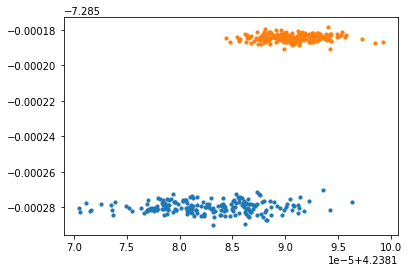

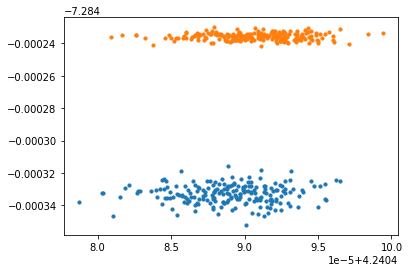

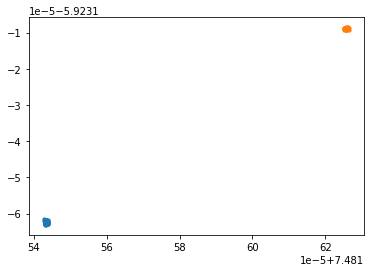

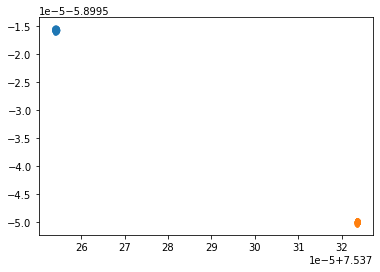

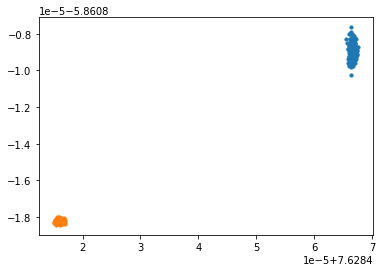

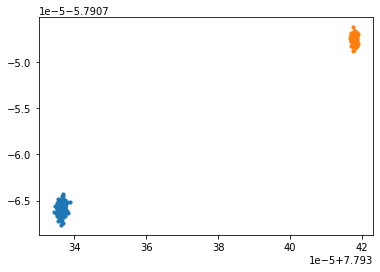

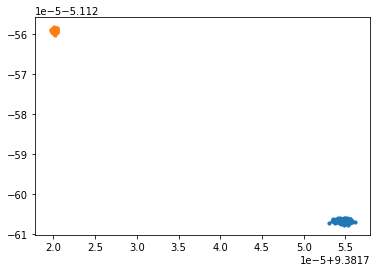

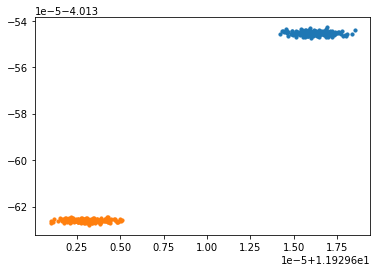

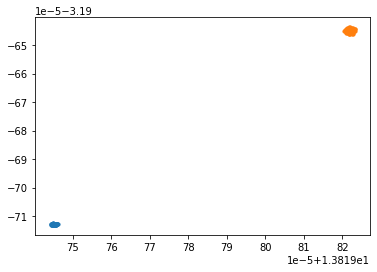

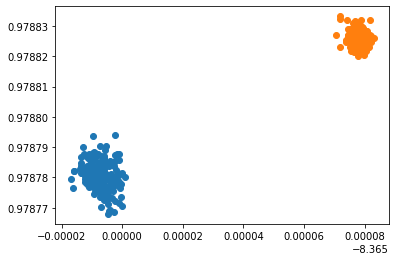

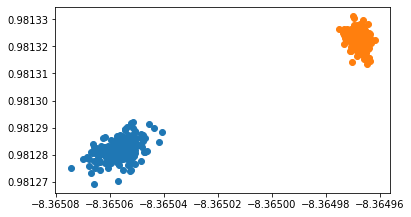

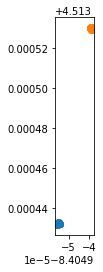

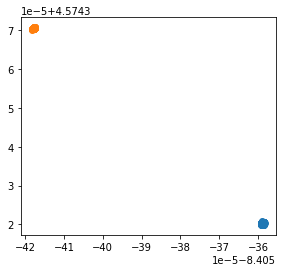

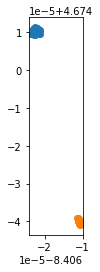

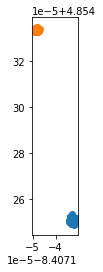

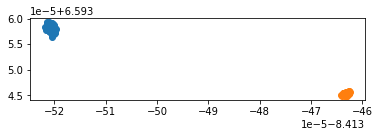

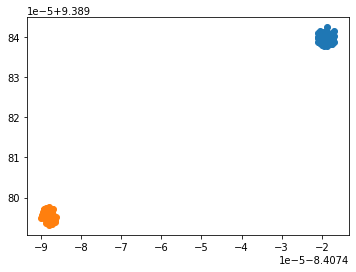

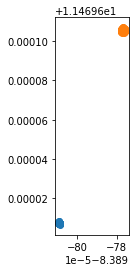

In [2]:
paramsDF = pd.read_csv("BennecchiData.csv")

#Inputs are the dataframe of observations, a list of the names of the objects, the number of objects, the number of samples you want to do the err calculations

convert_to_primary_centric(paramsDF,['Lempo','Hiisi','Paha'],3,200)

In [ ]:
#This function makes a scatter plot based on the data given (x,y) data points
def plot_scatter(array,dictionary, words):
    for i in words:
            x, y = array[dictionary[i]]
            plt.scatter(x, y, color = 'red')
            if dictionary[i]==2:
                plt.text(x-0.008,y+0.012,i,fontsize=9)
            else:
                plt.text(x+0.002,y+0.006,i,fontsize=9)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

In [8]:
primary = Horizons(id="eris",location=None,epochs=dateList)

NameError: name 'dateList' is not defined